In [40]:
import os
import typing
from sklearn.gaussian_process.kernels import *
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split

In [41]:
# Set `EXTENDED_EVALUATION` to `True` in order to visualize your predictions.
EXTENDED_EVALUATION = False
EVALUATION_GRID_POINTS = 300  # Number of grid points used in extended evaluation
EVALUATION_GRID_POINTS_3D = 50  # Number of points displayed in 3D during evaluation


# Cost function constants
COST_W_UNDERPREDICT = 25.0
COST_W_NORMAL = 1.0
COST_W_OVERPREDICT = 10.0


class Model(object):
    """
    Model for this task.
    You need to implement the fit_model and predict methods
    without changing their signatures, but are allowed to create additional methods.
    """

    def __init__(self):
        """
        Initialize your model here.
        We already provide a random number generator for reproducibility.
        """
        self.rng = np.random.default_rng(seed=0)
        self.ny = Nystroem(random_state=1, n_components=500,kernel='rbf')
        self.blr = BayesianRidge()


    def make_predictions(self, test_features: np.ndarray) -> typing.Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Predict the pollution concentration for a given set of locations.
        :param test_features: Locations as a 2d NumPy float array of shape (NUM_SAMPLES, 2)
        :return:
            Tuple of three 1d NumPy float arrays, each of shape (NUM_SAMPLES,),
            containing your predictions, the GP posterior mean, and the GP posterior stddev (in that order)
        """

        # TODO: Use your GP to estimate the posterior mean and stddev for each location here
        X = self.ny.transform(test_features)
        gp_mean,gp_std = self.blr.predict(X,return_std=True)

        # TODO: Use the GP posterior to form your predictions here
        # predictions = gp_mean+gp_std*0.01
        # predictions = gp_mean-gp_std*0.01
        predictions = gp_mean

        return predictions, gp_mean, gp_std

    def fitting_model(self, train_GT: np.ndarray,train_features: np.ndarray):
        """
        Fit your model on the given training data.
        :param train_features: Training features as a 2d NumPy float array of shape (NUM_SAMPLES, 2)
        :param train_GT: Training pollution concentrations as a 1d NumPy float array of shape (NUM_SAMPLES,)
        """

        # TODO: Fit your model here
        X = self.ny.fit_transform(train_features)
        self.blr.fit(X,train_GT)




def cost_function(ground_truth: np.ndarray, predictions: np.ndarray) -> float:
    """
    Calculates the cost of a set of predictions.

    :param ground_truth: Ground truth pollution levels as a 1d NumPy float array
    :param predictions: Predicted pollution levels as a 1d NumPy float array
    :return: Total cost of all predictions as a single float
    """
    assert ground_truth.ndim == 1 and predictions.ndim == 1 and ground_truth.shape == predictions.shape

    # Unweighted cost
    cost = (ground_truth - predictions) ** 2
    weights = np.ones_like(cost) * COST_W_NORMAL

    # Case i): underprediction
    mask_1 = predictions < ground_truth
    weights[mask_1] = COST_W_UNDERPREDICT

    # Case ii): significant overprediction
    mask_2 = (predictions >= 1.2*ground_truth)
    weights[mask_2] = COST_W_OVERPREDICT

    # Weigh the cost and return the average
    return np.mean(cost * weights)



def perform_extended_evaluation(model: Model, output_dir: str = '/results'):
    """
    Visualizes the predictions of a fitted model.
    :param model: Fitted model to be visualized
    :param output_dir: Directory in which the visualizations will be stored
    """
    print('Performing extended evaluation')
    fig = plt.figure(figsize=(30, 10))
    fig.suptitle('Extended visualization of task 1')

    # Visualize on a uniform grid over the entire coordinate system
    grid_lat, grid_lon = np.meshgrid(
        np.linspace(0, EVALUATION_GRID_POINTS - 1, num=EVALUATION_GRID_POINTS) / EVALUATION_GRID_POINTS,
        np.linspace(0, EVALUATION_GRID_POINTS - 1, num=EVALUATION_GRID_POINTS) / EVALUATION_GRID_POINTS,
    )
    visualization_xs = np.stack((grid_lon.flatten(), grid_lat.flatten()), axis=1)

    # Obtain predictions, means, and stddevs over the entire map
    predictions, gp_mean, gp_stddev = model.make_predictions(visualization_xs)
    predictions = np.reshape(predictions, (EVALUATION_GRID_POINTS, EVALUATION_GRID_POINTS))
    gp_mean = np.reshape(gp_mean, (EVALUATION_GRID_POINTS, EVALUATION_GRID_POINTS))
    gp_stddev = np.reshape(gp_stddev, (EVALUATION_GRID_POINTS, EVALUATION_GRID_POINTS))

    vmin, vmax = 0.0, 65.0
    vmax_stddev = 35.5

    # Plot the actual predictions
    ax_predictions = fig.add_subplot(1, 3, 1)
    predictions_plot = ax_predictions.imshow(predictions, vmin=vmin, vmax=vmax)
    ax_predictions.set_title('Predictions')
    fig.colorbar(predictions_plot)

    # Plot the raw GP predictions with their stddeviations
    ax_gp = fig.add_subplot(1, 3, 2, projection='3d')
    ax_gp.plot_surface(
        X=grid_lon,
        Y=grid_lat,
        Z=gp_mean,
        facecolors=cm.get_cmap()(gp_stddev / vmax_stddev),
        rcount=EVALUATION_GRID_POINTS_3D,
        ccount=EVALUATION_GRID_POINTS_3D,
        linewidth=0,
        antialiased=False
    )
    ax_gp.set_zlim(vmin, vmax)
    ax_gp.set_title('GP means, colors are GP stddev')

    # Plot the standard deviations
    ax_stddev = fig.add_subplot(1, 3, 3)
    stddev_plot = ax_stddev.imshow(gp_stddev, vmin=vmin, vmax=vmax_stddev)
    ax_stddev.set_title('GP estimated stddev')
    fig.colorbar(stddev_plot)

    # Save figure to pdf
    figure_path = os.path.join(output_dir, 'extended_evaluation.pdf')
    fig.savefig(figure_path)
    print(f'Saved extended evaluation to {figure_path}')

    plt.show()





In [42]:
# Load the training dateset and test features
X = np.loadtxt('train_x.csv', delimiter=',', skiprows=1)
y = np.loadtxt('train_y.csv', delimiter=',', skiprows=1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=1)

# Fit the model
print('Fitting model')
model = Model()
model.fitting_model(y_train,X_train)

# Predict on the test features
print('Predicting on test features')
pred,mean,std = model.make_predictions(X_test)
# print(pred)

print(cost_function(y_test,pred))
# print(y.shape)
# print(pred.shape)

Fitting model
Predicting on test features
2427.982586838818


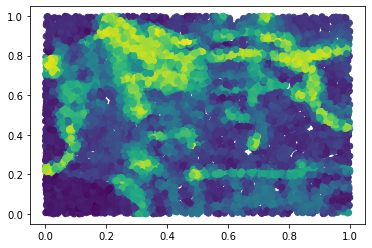

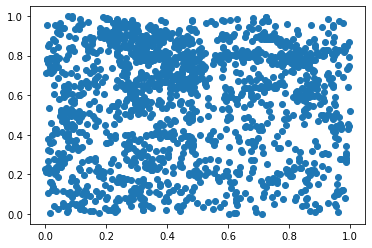

In [43]:
import numpy as np
from matplotlib import pyplot as plt


x2, y2 = X.T
plt.scatter(x2,y2,c=y)
plt.show()


X2 = np.loadtxt('test_x.csv', delimiter=',', skiprows=1)
x, y = X2.T
plt.scatter(x,y)
plt.show()